# Imports

In [1]:
import Thymio as th
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import threading

## Test pour avancer tout droit

In [2]:
### Setting up the origin and the kalman filter
current_pos = np.array([0,0,0])
current_speed = np.array([0,0,0])
z_predicted = np.concatenate([current_pos,current_speed]) #kalman_state
sigma_predicted = np.diag([0,0,0,0,0,0])

### Position goal
goal_pos = np.array([100,0])

print("Open thymio")
thymio = th.Thymio()
await thymio.initiateLock()
print("Thymio opened")

Open thymio
Thymio opened


### Autre solution

In [3]:
### Data storage for plotting
xdata, ydata, thetadata, Vleftdata, Vrightdata = [], [], [], [], []
iteration_times = []

while True:
    start_time = time.time()  # Capture start time
    thymio.navigate(current_pos, goal_pos)
    current_pos = z_predicted[:3] # Is used for the controller

    Vleft = thymio.getSpeedL()
    Vright = thymio.getSpeedR()

    xdata.append(current_pos[0])
    ydata.append(current_pos[1])
    thetadata.append(current_pos[2])
    Vleftdata.append(Vleft)
    Vrightdata.append(Vright)

    z_filtered, sigma_filtered= thymio.filtering_step(z_k_k_1 = z_predicted, 
                                    sigma_k_k_1 = sigma_predicted, 
                                    V_left_measure = Vleft, 
                                    V_right_measure = Vright, 
                                    camera_working=False)
    
    z_predicted, sigma_predicted = thymio.prediction_step(z_filtered, sigma_filtered)

    obstacle,detected = thymio.getObstaclePosition()
    if detected:
        print("Obstacle detected")
        
    if thymio.robot_close_waypoint(current_pos[:2], goal_pos[0], goal_pos[1]):
        print("Goal reached")
        thymio.set_var("motor.left.target", 0)
        thymio.set_var("motor.right.target", 0)
        break

    end_time = time.time()  # Capture end time
    iteration_time = end_time - start_time  # Compute iteration time
    iteration_times.append(iteration_time)  # Store iteration time
    print(f"Iteration time: {iteration_time:.6f} seconds")  # Print iteration time


Is the goal reached ?
False
Iteration time: 1.313241 seconds
Is the goal reached ?
False
Iteration time: 1.114875 seconds
Is the goal reached ?
False
Iteration time: 1.115484 seconds
Is the goal reached ?
True
Goal reached


In [4]:
thymio.set_var("motor.left.target", 0)
thymio.set_var("motor.right.target", 0)

In [5]:
print(np.mean(np.array(iteration_times)))

1.1812000274658203


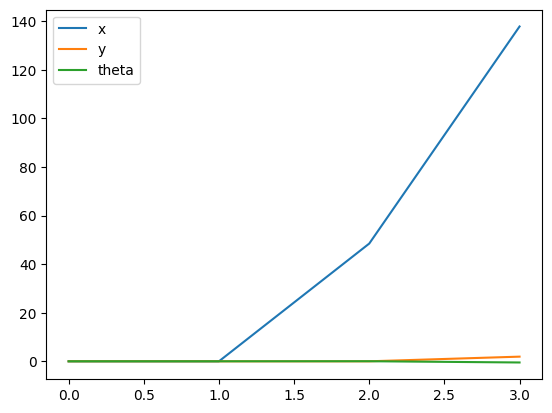

In [6]:
plt.plot(xdata, label='x')
plt.plot(ydata, label='y')
plt.plot(thetadata, label='theta')
plt.legend()

In [7]:
xdata

[0, 0.0, 48.45217391304348, 137.78658250101088]

In [8]:
ones = np.array([1, 1, 1, 1])
F = np.array([[1, 0], [-1, 0], [0, 1], [0, -1]])
goal_pos = np.array([100,0])
l=50

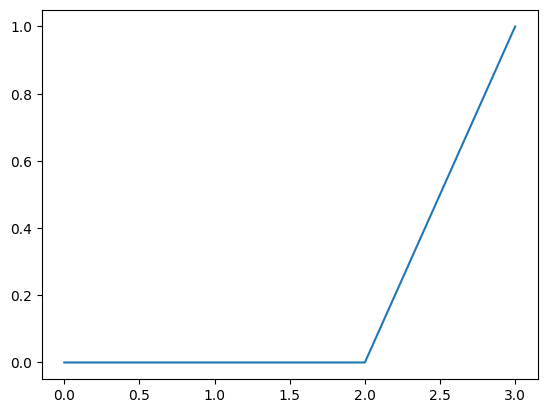

In [9]:
reached=[]
for i in range(len(xdata)):
    current_pos=np.array([xdata[i],ydata[i]])
    if all(F @ (current_pos - goal_pos) <= l * ones):
        reached.append(True)
    else:
        reached.append(False)

plt.plot(reached)

In [10]:
Vleftdata = np.array(Vleftdata)
Vrightdata = np.array(Vrightdata)

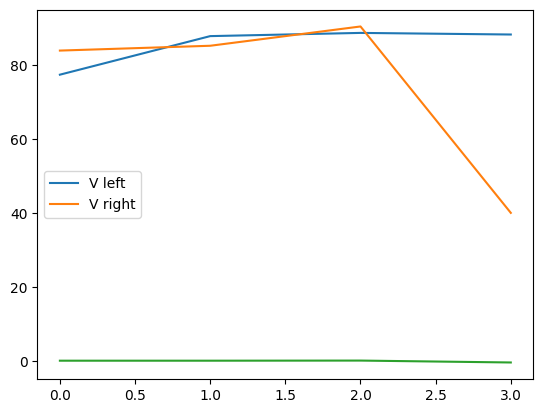

In [11]:
plt.plot(Vleftdata, label="V left")
plt.plot(Vrightdata, label="V right")
plt.plot(thetadata)
plt.legend()

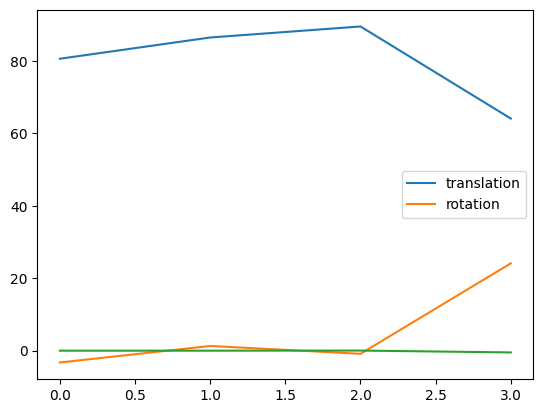

In [12]:
plt.plot((Vleftdata+Vrightdata)/2, label = "translation")
plt.plot((Vleftdata-Vrightdata)/2, label = "rotation")
plt.plot(thetadata)
plt.legend()

In [13]:
L = 46.75
theta_dot = (Vleftdata-Vrightdata)/2/L

In [14]:
print(np.array(thetadata))
print(theta_dot)

[ 0.          0.          0.03123426 -0.48312272]
[-0.06975122  0.02790049 -0.01860033  0.51615903]


In [24]:
Ts = 1.12
theta_int=[0]

theta_int=[theta_int[-1] + Ts*theta_dot[i] for i in range(len(theta_dot))]

In [25]:
theta_int

[-0.07812136712392466,
 0.031248546849569795,
 -0.02083236456637992,
 0.5780981167170426]

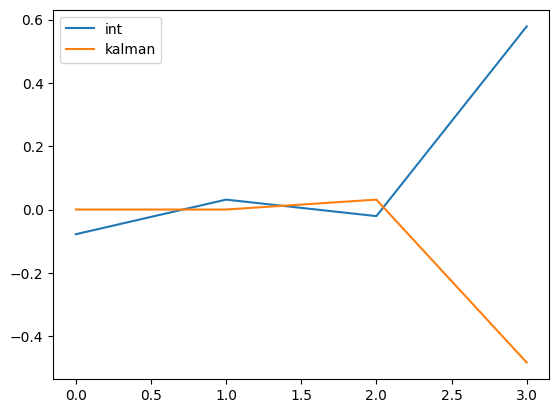

In [26]:
plt.plot(theta_int, label='int')
plt.plot(thetadata, label='kalman')
plt.legend()

In [27]:
V = (Vrightdata + Vleftdata)/2
Distance = [0]

for i in range(len(V)):
    Distance.append(Distance[-1] + Ts*V[i])

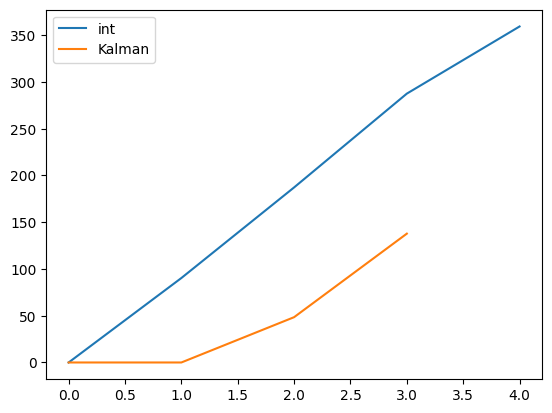

In [30]:
plt.plot(Distance, label="int")
plt.plot(xdata, label="Kalman")
plt.legend()

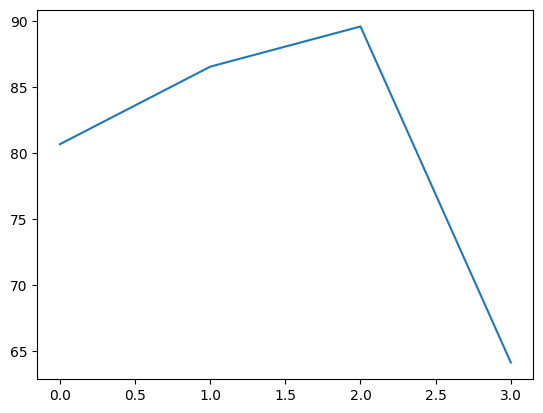

In [29]:
plt.plot(V)